# Ensemble Methods: VotingClassifier, StackingClassifier

Reminder: High bias implies an underfit model, high variance implies an overfit model. 

## First, a bagging method using a VotingClassifier will be used to reduce the amount of variance in the model. Then, a boosting method using a StackingClassifier will be run comparatively to reduce bias. 

- ensemble averaging methods (VotingClassifier): average predictions to reduce variance. 
- ensemble boosting methods (StackingClassifier): base estimators are built sequentially and one tries to reduce the bias of the combined estimator.
- Bagging methods work best with strong and complex models (e.g. where the data points are unpredictable), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).
- Model with high bias pays very little attention to the training data and oversimplifies the model.
- High variance models pays attention to training data and does not generalize on the data which it hasn’t seen before.



# VotingClassifier

In [5]:
# For model testing purposes, faster runtime for 455 row x 5 columns
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
from mlxtend.evaluate import bias_variance_decomp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time


# iris = datasets.load_breast_cancer()
# X = pd.DataFrame(iris.data[:, :5])  # we only take the first five features.
# y = pd.DataFrame(iris.target)
df_model = pd.DataFrame(pd.read_csv('df_Models.csv'))
X = df_model.iloc[:, :-1]
y = df_model.result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.unique()) # binary classfication
X_train

[1 0]


,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,...,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16
213,0.065378,0.002217,6.802315,1.582904,5.219412,1.637428,0.030765,-0.008015,0.016360,0.022397,...,0,255,0,0,0,0,0,0,0,0
1456,-0.039738,-0.033325,-7.612262,13.691864,-21.304125,-14.775005,-0.023379,0.018245,-0.033598,0.022042,...,0,0,0,0,0,0,0,0,0,1
1051,-0.010428,0.057962,5.181340,-3.742951,8.924291,6.538864,-0.002343,0.006849,0.102216,0.014142,...,0,255,0,0,0,0,0,0,0,0
418,-0.050279,0.073242,3.362287,4.133307,-0.771020,-4.249405,-0.013235,-0.050984,0.002597,-0.064939,...,0,0,0,0,0,0,0,0,0,0
1187,-0.024525,0.022684,0.619167,8.693164,-8.073997,-7.545311,-0.007992,-0.050382,-0.070313,-0.084514,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,0.035498,0.034964,7.216674,-0.374670,7.591344,6.436202,0.023753,-0.022862,0.012339,-0.018758,...,0,0,0,0,0,0,0,0,0,0
451,-0.113967,0.027477,-7.488886,-5.306175,-2.182711,-0.928140,-0.053126,-0.008978,0.006718,-0.046551,...,0,0,0,0,0,0,0,255,0,0
353,0.068189,0.020490,8.974092,5.829400,3.144692,1.551331,0.048617,-0.025898,0.003416,-0.027850,...,0,0,0,0,1,0,0,255,0,0
1177,-0.107511,0.001466,-10.595071,10.319227,-20.914297,-16.795926,-0.062122,0.012045,-0.000584,-0.017311,...,0,0,0,0,1,0,0,0,0,0


In [6]:
def create_pipe_ensemble(X_train, ensemble_clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    pipe = Pipeline([(clf_label, VotingClassifier(estimators=[
                          (clf_label+str(1), create_pipe(X_train, ensemble_clf.estimators[0][1])),
                          (clf_label+str(2), create_pipe(X_train, ensemble_clf.estimators[1][1])),
                          (clf_label+str(3), create_pipe(X_train, ensemble_clf.estimators[2][1])),
                          (clf_label+str(4), create_pipe(X_train, ensemble_clf.estimators[3][1])),
                          (clf_label+str(5), create_pipe(X_train, ensemble_clf.estimators[4][1])),
                          (clf_label+str(6), create_pipe(X_train, ensemble_clf.estimators[5][1])),
                          (clf_label+str(7), create_pipe(X_train, ensemble_clf.estimators[6][1])),
                          (clf_label+str(8), create_pipe(X_train, ensemble_clf.estimators[7][1]))
                                           ]))])
    return pipe

def clfy_report_ensemble(ensemble_voting, X_train, X_test, y_train, y_test, ensemble_params, cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    return search, train_accuracy, test_accuracy, auc, logloss
    """
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(ensemble_voting, ensemble_params, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])


classifiers = [
    SVC(probability=True),
    RandomForestClassifier(),
    LogisticRegression(),
    MLPClassifier(),
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

pipeline_classifiers=[]
for i in range(0,len(classifiers)):
    pipeline_classifiers.append(Pipeline (steps=[('preprocessor', preprocessor),
        ('clf'+str(i+1), classifiers[i])]))

from sklearn.ensemble import VotingClassifier
ensemble_voting = Pipeline(steps=[('ensemble', VotingClassifier(estimators=[
    ('svc', pipeline_classifiers[0]), 
    ('rdf' , pipeline_classifiers[1]),
    ('lgr' , pipeline_classifiers[2]),
    ('mlp', pipeline_classifiers[3]),
    ('gau', pipeline_classifiers[4]),
    ('ada', pipeline_classifiers[5]), 
    ('gbt', pipeline_classifiers[6]),
    ('xgb', pipeline_classifiers[7])], 
                                voting='soft', 
                                # weights = [1,2,3], 
                                n_jobs=-1))])

import pprint as pp
pp.pprint(sorted(ensemble_voting.get_params().keys())) # used to specify ensemble params, below. 

['ensemble',
 'ensemble__ada',
 'ensemble__ada__clf6',
 'ensemble__ada__clf6__algorithm',
 'ensemble__ada__clf6__base_estimator',
 'ensemble__ada__clf6__learning_rate',
 'ensemble__ada__clf6__n_estimators',
 'ensemble__ada__clf6__random_state',
 'ensemble__ada__memory',
 'ensemble__ada__preprocessor',
 'ensemble__ada__preprocessor__cat',
 'ensemble__ada__preprocessor__cat__imputer',
 'ensemble__ada__preprocessor__cat__imputer__add_indicator',
 'ensemble__ada__preprocessor__cat__imputer__copy',
 'ensemble__ada__preprocessor__cat__imputer__fill_value',
 'ensemble__ada__preprocessor__cat__imputer__missing_values',
 'ensemble__ada__preprocessor__cat__imputer__strategy',
 'ensemble__ada__preprocessor__cat__imputer__verbose',
 'ensemble__ada__preprocessor__cat__memory',
 'ensemble__ada__preprocessor__cat__onehot',
 'ensemble__ada__preprocessor__cat__onehot__categories',
 'ensemble__ada__preprocessor__cat__onehot__drop',
 'ensemble__ada__preprocessor__cat__onehot__dtype',
 'ensemble__ada__pre

Best Parameters: {'ensemble__ada__clf6__n_estimators': 133, 'ensemble__ada__clf6__learning_rate': 1.0555555555555556}

Training Accuracy: 0.82
Test Accuracy: 0.69



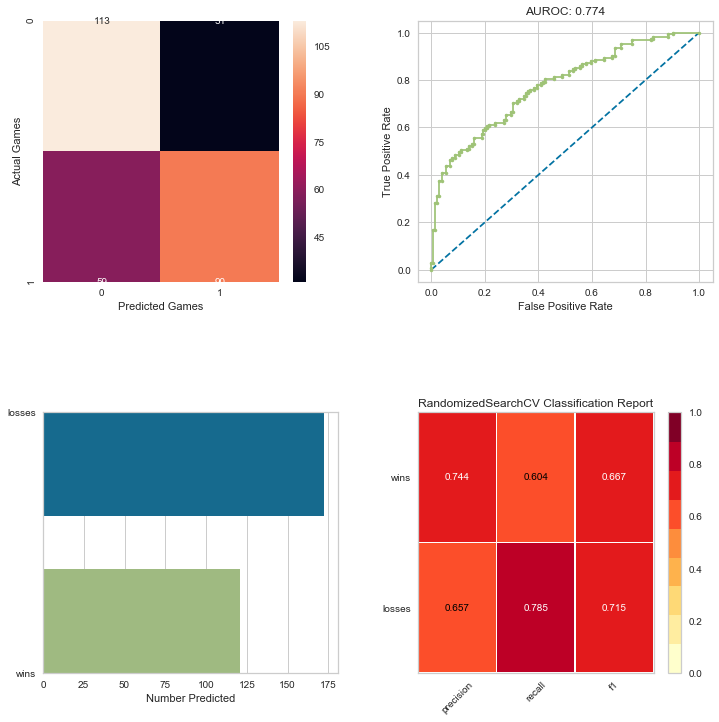

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ensemble',
                                              VotingClassifier(estimators=[('svc',
                                                                            Pipeline(memory=None,
                                                                                     steps=[('preprocessor',
                                                                                             ColumnTransformer(n_jobs=None,
                                                                                                               remainder='drop',
                                                                                                               sparse_threshold=0.3,
                                                                                                               transformer_weights=None,
                                   

In [31]:
ensemble_params=[
    { # SVC
        'ensemble__svc__clf1__kernel': ['rbf', 'linear', 'sigmoid'],
        'ensemble__svc__clf1__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'ensemble__rdf__clf2__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__rdf__clf2__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
        'ensemble__lgr__clf3__C': np.logspace(start=-10, stop=10, num=21),
        'ensemble__lgr__clf3__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'ensemble__mlp__clf4__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'ensemble__gau__clf5__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'ensemble__ada__clf6__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__ada__clf6__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'ensemble__gbt__clf7__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__gbt__clf7__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'ensemble__xgb__clf8__max_depth': [2,3,4,5],
    'ensemble__xgb__clf8__booster': ['gbtree', 'gblinear', 'dart']
    }
]
timer_start=time.time()
search_ens, train_accuracy, test_accuracy, auc, logloss = clfy_report_ensemble(ensemble_voting, X_train, X_test, y_train, y_test, ensemble_params, cv=10)
print(search_ens, train_accuracy, test_accuracy, auc, logloss)

In [32]:
print("Time taken:", round(-(timer_start-time.time()),2),'seconds. ')
del timer_start

Time taken: 244.65 seconds. 


# StackingClassifier

In [10]:
classifiers = [
    ('svc',  SVC(probability=True)       ),
    ('rdf' , RandomForestClassifier()    ),
    ('lgr' , LogisticRegression()        ),
    ('mlp',  MLPClassifier()             ),
    ('gau',  GaussianNB()                ),
    ('ada',  AdaBoostClassifier()        ),
    ('gbt',  GradientBoostingClassifier()),
    ('xgb',  XGBClassifier()             )   
    ]

from sklearn.ensemble import StackingClassifier
stack_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())
pipe_stack_clf = Pipeline(steps=[('preproc', preprocessor), ('stack', stack_clf)])

In [11]:
pp.pprint(sorted(pipe_stack_clf.get_params().keys())) # used to specify pipe_stack_clf params, below. 

['memory',
 'preproc',
 'preproc__cat',
 'preproc__cat__imputer',
 'preproc__cat__imputer__add_indicator',
 'preproc__cat__imputer__copy',
 'preproc__cat__imputer__fill_value',
 'preproc__cat__imputer__missing_values',
 'preproc__cat__imputer__strategy',
 'preproc__cat__imputer__verbose',
 'preproc__cat__memory',
 'preproc__cat__onehot',
 'preproc__cat__onehot__categories',
 'preproc__cat__onehot__drop',
 'preproc__cat__onehot__dtype',
 'preproc__cat__onehot__handle_unknown',
 'preproc__cat__onehot__sparse',
 'preproc__cat__steps',
 'preproc__cat__verbose',
 'preproc__n_jobs',
 'preproc__num',
 'preproc__num__imputer',
 'preproc__num__imputer__add_indicator',
 'preproc__num__imputer__copy',
 'preproc__num__imputer__fill_value',
 'preproc__num__imputer__missing_values',
 'preproc__num__imputer__strategy',
 'preproc__num__imputer__verbose',
 'preproc__num__memory',
 'preproc__num__scaler',
 'preproc__num__scaler__copy',
 'preproc__num__scaler__with_mean',
 'preproc__num__scaler__with_std

Best Parameters: {'stack__xgb__max_depth': 3, 'stack__xgb__booster': 'gbtree'}

Training Accuracy: 0.64
Test Accuracy: 0.7



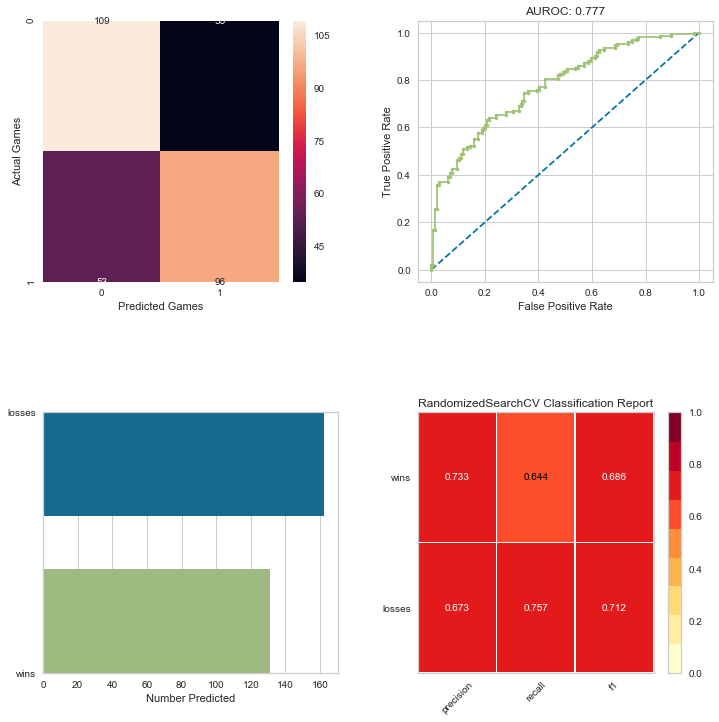

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preproc',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                         

In [29]:
pipe_stack_clf_params=[
    { # SVC
        'stack__svc__kernel': ['rbf', 'linear', 'sigmoid'],
        'stack__svc__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'stack__rdf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'stack__rdf__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
        'stack__lgr__C': np.logspace(start=-10, stop=10, num=21),
        'stack__lgr__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
        'stack__mlp__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'stack__gau__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'stack__ada__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'stack__ada__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'stack__gbt__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'stack__gbt__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
        'stack__xgb__max_depth': [2,3,4,5],
        'stack__xgb__booster': ['gbtree', 'gblinear', 'dart']
    }
]
# print(search, train_accuracy, test_accuracy, auc, logloss)
timer_start=time.time()
search_stk, train_accuracy, test_accuracy, auc, logloss = clfy_report_ensemble(pipe_stack_clf, X_train, X_test, y_train, y_test, pipe_stack_clf_params, cv=10)
print(search_stk, train_accuracy, test_accuracy, auc, logloss)

In [30]:
print("Time taken:", round(-(timer_start-time.time()),2),'seconds. ')
del timer_start

Time taken: 829.58 seconds. 


## StackedClassifier loss, bias, variance

In [13]:
timer_start=time.time()
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        stack_clf, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
        loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print("Time taken:", round(-(timer_start-time.time()),2),'seconds. ')
del timer_start

Average expected loss: 0.336
Average bias: 0.314
Average variance: 0.140


## VotingClassifier loss, bias, variance

In [28]:
timer_start=time.time()
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#         ensemble_voting[0], np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
    VotingClassifier(estimators=[
        classifiers[0], 
        classifiers[1],
        classifiers[2],
        classifiers[3],
        classifiers[4],
        classifiers[5], 
        classifiers[6],
        classifiers[7]], 
                        voting='soft', 
                        # weights = [1,2,3], 
                        n_jobs=-1),
        np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), 
        loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print("Time taken:", round(-(timer_start-time.time()),2),'seconds. ')
del timer_start

Average expected loss: 0.310
Average bias: 0.297
Average variance: 0.101
Time taken: -652.39 seconds. 


- ensemble averaging methods (VotingClassifier): average predictions to reduce variance. 
- ensemble boosting methods (StackingClassifier): base estimators are built sequentially and one tries to reduce the bias of the combined estimator.
- Bagging methods work best with strong and complex models (e.g. where the data points are unpredictable), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).
- Model with high bias pays very little attention to the training data and oversimplifies the model.
- High variance models pays attention to training data and does not generalize on the data which it hasn’t seen before.



# Results:

#### From these results, the both of the VotingClassifier and StackingClassifier models built have:
- very low variance  (~0.10 - 0.14)
- low-moderate loss (~0.31 - 0.34)
- low-moderate bias (~0.30 - 0.32)  </ul>
The results above implies that the final model needs to use the StackingClassifier, to lower bias. However, the 10-fold cross-validated accuracy is around the same for the VotingClassifier (Training Accuracy: 0.82, Test Accuracy: 0.69) compared to the StackingClassifier (Training Accuracy: 0.64, Test Accuracy: 0.7). 
### Therefore, either VotingClassifier or StackingClassifier could be used as the primary prediction model.

# Create a bracket using both methods. 

In [34]:
df_predict = pd.read_csv('../2020Data/LastYears_SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [35]:
def get_year_team1_team2(ID):
    """Return a tuple with the year, team1 and team2
    for each ID in the sample submission file of possible matches."""
    return (int(x) for x in ID.split('_'))

In [38]:
df_features = pd.read_csv('df_features.csv')
diff = []
data = []

for i, row in df_predict.iterrows():

    year, team1, team2 = get_year_team1_team2(row.ID)

    # Save 2018 stats/features for the first ID:
    team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

    # Save 2018 stats/features for the first ID:
    team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

    diff = team1 - team2

    data.append(diff)

n_poss_games = len(df_predict)
columns = df_features.columns.get_values()
final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)

# StackingClassifier Bracket Predictions

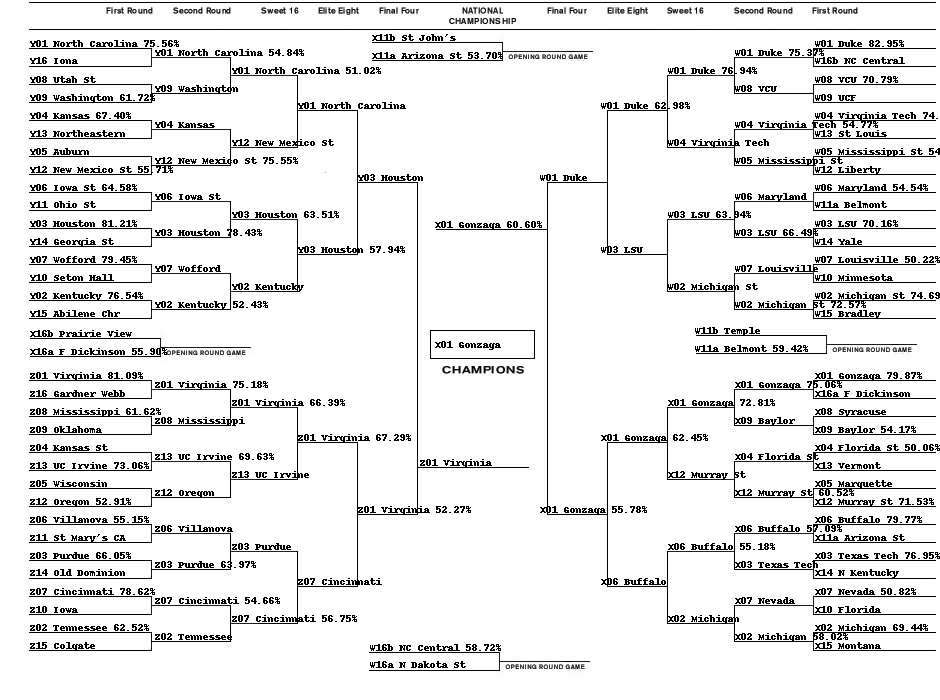

In [39]:
predictions = search_stk.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions
df_predict.to_csv('search_stk.csv', index=False)

from bracketeer import build_bracket
b = build_bracket(
        outputPath='search_stk.png', # in /Ryan
        submissionPath='search_stk.csv',
        teamsPath='../2020Data/MDataFiles_Stage1/MTeams.csv',
        seedsPath='../2020Data/MDataFiles_Stage1/MNCAATourneySeeds.csv',
        slotsPath='../2020Data/MDataFiles_Stage1/MNCAATourneySlots.csv',
        year=2019
)
from IPython.display import Image
Image(filename='search_stk.png')

# VotingClassifier Bracket Predictions

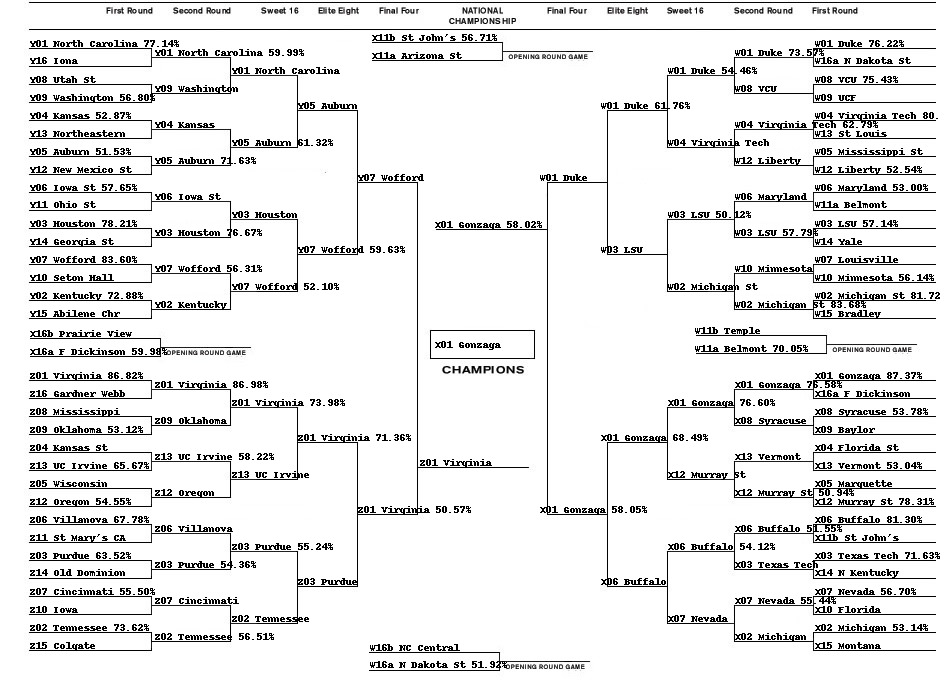

In [40]:
predictions = search_ens.predict_proba(final_predictions)[:, 1]
clipped_predictions = np.clip(predictions, 0.05, 0.95)
df_predict.Pred = clipped_predictions
df_predict.to_csv('search_ens.csv', index=False)

from bracketeer import build_bracket
b = build_bracket(
        outputPath='search_ens.png', # in /Ryan
        submissionPath='search_ens.csv',
        teamsPath='../2020Data/MDataFiles_Stage1/MTeams.csv',
        seedsPath='../2020Data/MDataFiles_Stage1/MNCAATourneySeeds.csv',
        slotsPath='../2020Data/MDataFiles_Stage1/MNCAATourneySlots.csv',
        year=2019
)
from IPython.display import Image
Image(filename='search_ens.png')